In [1]:
%cd ..
import os
import time
from typing import TYPE_CHECKING, Any, Dict, List, Optional, Set, Tuple, Union

/work/apperception/shared/apperception-yousef


In [2]:
from apperception.database import database

from apperception.utils import transformation
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def fetch_camera_config(filename: str, database):
    query = f"""
    CREATE OR REPLACE FUNCTION ST_XYZ (g geometry) RETURNS real[] AS $$
        BEGIN
            RETURN ARRAY[ST_X(g), ST_Y(g), ST_Z(g)];
        END;
    $$ LANGUAGE plpgsql;

    SELECT
        cameraId,
        ST_XYZ(egoTranslation),
        egoRotation,
        ST_XYZ(cameraTranslation),
        cameraRotation,
        cameraIntrinsic,
        frameNum,
        fileName,
        cameraHeading,
        egoHeading,
        timestamp
    FROM Cameras
    WHERE
        fileName = '{filename}'
    ORDER BY cameraId ASC, frameNum ASC;
    """
    result = database.execute(query)[0]
    print(result)
    camera_config = {
        "cameraId": result[0],
        "egoTranslation": result[1],
        "egoRotation": result[2],
        "cameraTranslation": result[3],
        "cameraRotation": result[4],
        "cameraIntrinsic": result[5],
        "frameNum": result[6],
        "fileName": result[7],
        "cameraHeading": result[8],
        "egoHeading": result[9],
        "timestamp": result[10],
    }
    return camera_config

In [4]:
def fetch_trajectory(itemId: str, time: str, database):
    query = f"""
        CREATE OR REPLACE FUNCTION ST_XYZ (g geometry) RETURNS real[] AS $$
        BEGIN
            RETURN ARRAY[ST_X(g), ST_Y(g), ST_Z(g)];
        END;
        $$ LANGUAGE plpgsql;

        SELECT ST_XYZ(valueAtTimestamp(trajCentroids, '{time}'))
        FROM Item_General_Trajectory as final
        WHERE itemId = '{itemId}';
        """

    traj = database.execute(query)[0][0]
    return traj

In [5]:
def world_to_pixel(
    camera_config: dict, world_coords: Union[np.ndarray, Tuple[float, float, float]]
):
    traj_2d = transformation(world_coords, camera_config)
    return traj_2d

In [17]:
def overlay_objects(frame, itemIds: Set[str], camera_config, database):
    time = camera_config["timestamp"]
    pixels = {}
    for itemId in itemIds:
        current_traj_point = fetch_trajectory(itemId=itemId, time=time, database=database)

        if None not in current_traj_point:
            print(current_traj_point)
            current_pixel = world_to_pixel(camera_config, current_traj_point)
            print(current_pixel)
            pixels[itemId] = current_pixel

    for itemId in pixels:
        pixel = pixels[itemId]
        cv2.circle(
            frame,
            tuple([int(pixel[0][0]), int(pixel[1][0])]),
            10,
            (0, 255, 0),
            -1,
        )
    return frame

In [19]:
prefix = "/work/apperception/data/raw/nuScenes/full-dataset-v1.0/Mini/"
filename = "sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657111762404.jpg"
itemIds = ['scene-0757-CAM_FRONT_obj_44', 'scene-0757-CAM_FRONT_obj_23']
frame_im = cv2.imread(prefix + filename)

camera_config = fetch_camera_config(filename, database)
# print(camera_config)
overlayed = overlay_objects(frame_im, itemIds, camera_config, database)

('scene-0757-CAM_FRONT', [319.15524, 664.0982, 0.0], [-0.19523013, 0.004754057, -0.009932777, -0.98069566], [317.5546, 664.785, 1.4718987], [-0.57870734, 0.59319174, 0.38775843, -0.40356505], [[1252.8131, 0.0, 826.58813], [0.0, 1252.8131, 469.98465], [0.0, 0.0, 1.0]], 244, 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657111762404.jpg', 68.06685, 67.47895, datetime.datetime(2018, 8, 30, 12, 25, 11, 762404, tzinfo=datetime.timezone.utc))
[301.36765, 676.2342, 0.0]
[[-35800.73135315]
 [  1619.12134709]]
[301.1245, 674.58746, 0.0]
[[-34355.22185374]
 [  1575.27933872]]


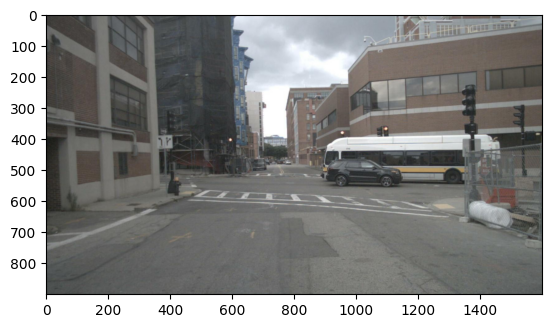

In [20]:
plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))